# Task 2

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import plot_confusion_matrix

### Helper Functions

In [12]:
def scree_plot(n_comp):
    n_comp = 20
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(data)
    scree_df = pd.DataFrame({'exp_var':pca.explained_variance_ratio_,
                 'PC':[i for i in range(1,n_comp+1)]})
    colors = [n_comp * ['blue'] + (20-n_comp) * ['red'] ]
    scree_df['colors'] = colors[0]
    sns.barplot(x='PC',y="exp_var", 
               data=scree_df, color="c");
    plt.tight_layout()
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Varaince')

def pcplot2d():
    pca = PCA(n_components=2)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2'])
    
    pc_df['class'] =labels
    sns.lmplot( x="PC1", y="PC2",
      data=pc_df, 
      fit_reg=False, 
        hue='class', 
      legend=True,
      scatter_kws={"s": 80}) 
    
def pcplot3d():
    pca = PCA(n_components=3)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2','PC3'])

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c=labels,depthshade=False)
    
def training_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_test_score']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_test_score']

    plt.figure(figsize=(6,4),dpi=100)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Accuracy Score')
    # plt.title('Bayes Models: Number of Principal Components')
    plt.legend(loc=(.6,0.08))

def training_time_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_fit_time']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_fit_time']

    plt.figure(figsize=(6,4),dpi=100)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Training Time')
    plt.legend(loc=(.6,0.08))

def model_eval(model, X_test, y_test):
    ypred = model.predict(X_test)
    results = {'Accuracy' : [accuracy_score(y_test, ypred)],
               'F1': [f1_score(y_test, ypred, average='micro')], 
               'Precision': [precision_score(y_test, ypred, average='micro')],
                'Recall': [recall_score(y_test, ypred, average='micro')]}
    results_df = pd.DataFrame(results)
    
    results_df = results_df.style.hide_index()
    return results_df

def confusion_matrix(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [13]:
#load data chunks and converts to numpy arrays
def load_data_chunks():
    raw_face = np.array(loadmat('./data/data.mat')['face'])
    raw_pose = np.array(loadmat('./data/pose.mat')['pose'])
    raw_illum = np.array(loadmat('./data/illumination.mat')['illum'])
    aug_neutral = np.load('data/aug_neutral.npy', allow_pickle=True)
    aug_smile = np.load('data/aug_smile.npy', allow_pickle=True)
    return raw_face, (raw_pose, raw_illum), (aug_neutral,aug_smile)

def make_pose_dataset(raw_pose, num_subjects, augmented=False):
    pose_dataset = []
    pose_labels = []
    if augmented == False:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
    else:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
        for subject in range(num_subjects):
            for pose in range(21):
                img = raw_pose[1][:,pose,subject].reshape((40,48))
                img = np.flip(np.rot90(img)).reshape((48*40))
                pose_dataset.append(img)
                pose_labels.append(subject)
                
    pose_dataset = np.array(pose_dataset)
    pose_labels = np.transpose(np.array(pose_labels))
    return pose_dataset, pose_labels

### load data and create dataset


In [14]:
#load data chunks
raw_face, raw_pose, aug_data = load_data_chunks()
#create face dataset
data, labels = make_pose_dataset(raw_pose, num_subjects=10, augmented=False)
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, random_state=42, shuffle='true', stratify=labels)
print(X_train.shape)
print(X_test.shape)

(117, 1920)
(13, 1920)


# Data Exploration

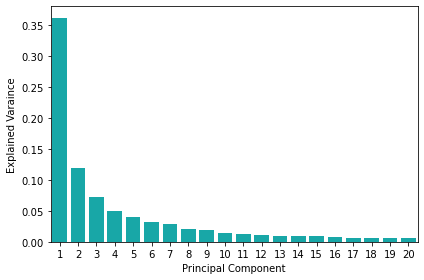

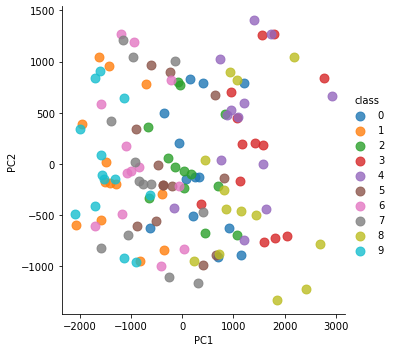

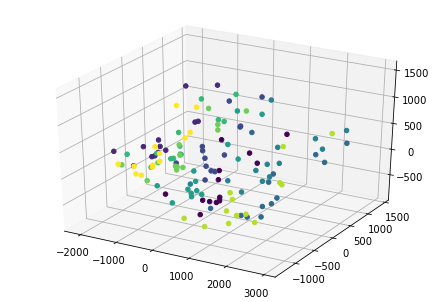

In [15]:
scree_plot(n_comp=16)
pcplot2d()
pcplot3d()

# Gaussian Bayes

In [16]:
#Pipeline Components
scaler = StandardScaler()
pca = PCA()
gnb = GaussianNB()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
param_grid = {
    'pca__n_components': [i for i in range(1,40)]
}

In [17]:
#pipelines
pipe_with_scaling = Pipeline(steps=[('scaler', scaler),('pca', pca), ('bayes', gnb)])
pipe_without_scaling = Pipeline(steps=[('pca', pca), ('bayes', gnb)])
pipes = [pipe_without_scaling, pipe_with_scaling]

In [172]:
best_score = []
best_params = []
with_scaling = []
num_sub = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
for i in range(len(num_sub)):
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub[i], augmented=False)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)
    search = GridSearchCV(pipe_without_scaling, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    search.fit(X_train, y_train)
    best_score.append(search.best_score_)
    best_params.append(search.best_params_)
results_og = pd.DataFrame({'Number of Subjects':num_sub, 'Best Params':best_params, 'Best Score': best_score})
print(results_og)

    Number of Subjects                Best Params  Best Score
0                   10  {'pca__n_components': 37}    0.838043
1                   15  {'pca__n_components': 37}    0.788571
2                   20  {'pca__n_components': 39}    0.696392
3                   25  {'pca__n_components': 39}    0.712332
4                   30  {'pca__n_components': 39}    0.643944
5                   35  {'pca__n_components': 39}    0.584342
6                   40  {'pca__n_components': 39}    0.593914
7                   45  {'pca__n_components': 39}    0.619802
8                   50  {'pca__n_components': 38}    0.601709
9                   55  {'pca__n_components': 33}    0.598680
10                  60  {'pca__n_components': 39}    0.574032
11                  65  {'pca__n_components': 37}    0.567105


In [18]:
best_score = []
best_params = []
with_scaling = []
num_sub = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
for i in range(len(num_sub)):
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub[i], augmented=True)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)
    search = GridSearchCV(pipe_without_scaling, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    search.fit(X_train, y_train)
    best_score.append(search.best_score_)
    best_params.append(search.best_params_)
results_aug = pd.DataFrame({'Number of Subjects':num_sub, 'Best Params':best_params, 'Best Score': best_score})
print(results_aug)

    Number of Subjects                Best Params  Best Score
0                   10  {'pca__n_components': 36}    0.882232
1                   15  {'pca__n_components': 39}    0.873579
2                   20  {'pca__n_components': 39}    0.813794
3                   25  {'pca__n_components': 38}    0.802614
4                   30  {'pca__n_components': 38}    0.770124
5                   35  {'pca__n_components': 38}    0.756314
6                   40  {'pca__n_components': 38}    0.727146
7                   45  {'pca__n_components': 38}    0.709520
8                   50  {'pca__n_components': 39}    0.722222
9                   55  {'pca__n_components': 39}    0.737965
10                  60  {'pca__n_components': 39}    0.708069
11                  65  {'pca__n_components': 39}    0.698830


In [19]:
x1, y1, = results_og['Number of Subjects'], results_og['Best Score']
x2, y2, = results_aug['Number of Subjects'], results_aug['Best Score']
plt.plot(x1,y1,c='orange',label ='Original Data')
plt.plot(x2,y2, label='Augmented Data')
plt.xlabel('Number of Subjects')
plt.ylabel('Mean Accuracy Score')
plt.title('stuff')
plt.legend()

NameError: name 'results_og' is not defined

## Best Bayes Model

In [29]:
data, labels = make_pose_dataset(raw_pose, num_subjects=15, augmented=True)
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)

In [30]:
scaler = StandardScaler()
pca = PCA(n_components=39)
gnb = GaussianNB()
best_pipe = Pipeline(steps=[('scaler', scaler),('pca', pca), ('bayes', gnb)])

In [31]:
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=39)),
                ('bayes', GaussianNB())])

In [32]:
model_eval(best_pipe, X_test, y_test)

Accuracy,F1,Precision,Recall
0.843137,0.843137,0.843137,0.843137


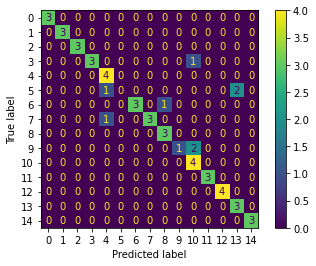

In [33]:
plot_confusion_matrix(best_pipe, X_test, y_test)

### Bayes Model Selection

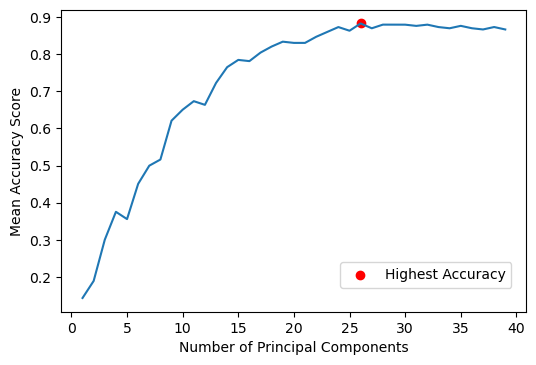

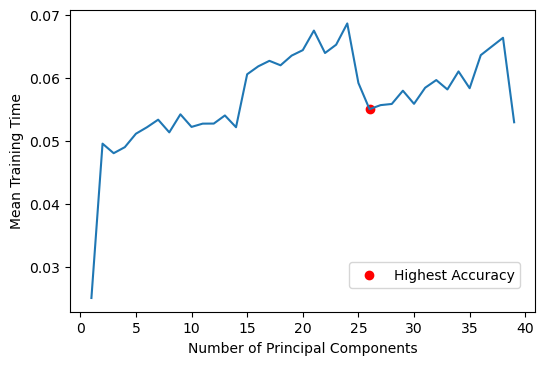

In [101]:
training_plot(bayes_search)
training_time_plot(bayes_search)

#### testing

In [102]:
model_eval(bayes_search, X_test, y_test)

Accuracy,F1,Precision,Recall
0.823529,0.823529,0.823529,0.823529


# KNN

In [ ]:
distances = ['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis']

In [8]:
scaler = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier()
param_grid = {
    'pca__n_components': [i for i in range(5,30,5)],
    'knn__n_neighbors' : [i for i in range(1,11)],  
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski'],
    'knn__weights' : ['uniform','distance'],
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

In [9]:
pipe = Pipeline(steps=[('scaler', scaler),('pca', pca), ('knn', knn)])
knn_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [10]:
best_score = []
best_params = []
with_scaling = []
num_sub = [10, 20, 30, 40, 50, 60 ]
for i in range(len(num_sub)):
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub[i], augmented=True)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)
    search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    search.fit(X_train, y_train)
    best_score.append(search.best_score_)
    best_params.append(search.best_params_)
knn_results = pd.DataFrame({'Number of Subjects':num_sub, 'Best Params':best_params, 'Best Score': best_score})
print(knn_results)
# plt.plot(results['Number of Subjects'], results['Best Score'])

   Number of Subjects                                        Best Params  \
0                  10  {'knn__metric': 'manhattan', 'knn__n_neighbors...   
1                  20  {'knn__metric': 'manhattan', 'knn__n_neighbors...   
2                  30  {'knn__metric': 'manhattan', 'knn__n_neighbors...   
3                  40  {'knn__metric': 'manhattan', 'knn__n_neighbors...   
4                  50  {'knn__metric': 'manhattan', 'knn__n_neighbors...   
5                  60  {'knn__metric': 'manhattan', 'knn__n_neighbors...   

   Best Score  
0    0.875674  
1    0.831774  
2    0.760323  
3    0.770455  
4    0.767974  
5    0.755448  


In [143]:
results = pd.DataFrame(knn_search.cv_results_)
results = results[['param_knn__n_neighbors',
                   'param_pca__n_components', 'mean_test_score',
                   'mean_fit_time','mean_score_time']]
results.sort_values(by=['mean_test_score'], inplace=True, ascending=False)
results.head(5)


,param_knn__n_neighbors,param_pca__n_components,mean_test_score,mean_fit_time,mean_score_time
659,1,30,0.882232,0.061246,0.005412
657,1,28,0.875727,0.056370,0.007278
717,2,28,0.875727,0.055203,0.004981
1078,8,29,0.875674,0.061001,0.006165
715,2,26,0.875674,0.058391,0.005784


#### testing

In [38]:
model_eval(knn_search, X_test, y_test)

Accuracy,F1,Precision,Recall
0.882353,0.882353,0.882353,0.882353
